# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

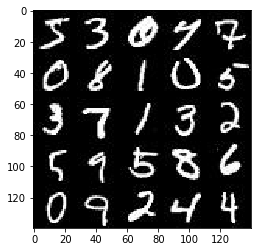

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

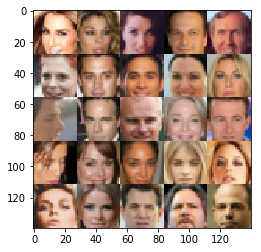

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(dtype=tf.float32,shape=(None, image_width, image_height, image_channels),name='input_real')
    input_z = tf.placeholder(dtype=tf.float32,shape=(None, z_dim),name='input_z')
    learn_rate = tf.placeholder(dtype=tf.float32,shape=(),name='learn_rate')
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope("discriminator", reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.nn.dropout(relu1,keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(relu2,keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(relu3,keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    alpha = 0.2
    keep_prob = 0.8
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #x1 = tf.nn.dropout(x1,keep_prob)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #x2 = tf.nn.dropout(x2,keep_prob)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #x3 = tf.nn.dropout(x3,keep_prob)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = 0.5 * tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    # Build the model
    g_model = generator(input_z, out_channel_dim)
    # g_model is the generator output
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_logits_fake)))
    '''
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    '''
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, image_channels = (data_shape[1],data_shape[2],data_shape[3])
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                #batch_images = batch_images*2 - 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate:learning_rate})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoch {}/{} Step {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 200 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2 Step 100... Discriminator Loss: 1.5028... Generator Loss: 0.7922
Epoch 1/2 Step 200... Discriminator Loss: 1.4023... Generator Loss: 0.8130


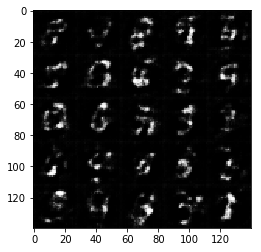

Epoch 1/2 Step 300... Discriminator Loss: 1.3512... Generator Loss: 1.1971
Epoch 1/2 Step 400... Discriminator Loss: 1.2291... Generator Loss: 0.8486


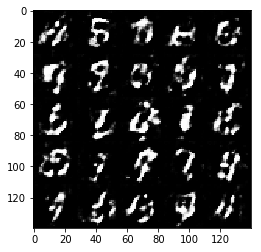

Epoch 1/2 Step 500... Discriminator Loss: 1.0737... Generator Loss: 1.0280
Epoch 1/2 Step 600... Discriminator Loss: 1.2429... Generator Loss: 1.1058


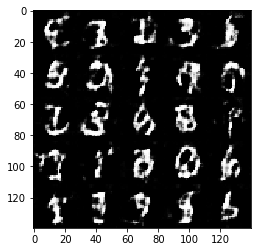

Epoch 1/2 Step 700... Discriminator Loss: 1.0599... Generator Loss: 1.1774
Epoch 1/2 Step 800... Discriminator Loss: 1.7761... Generator Loss: 0.5368


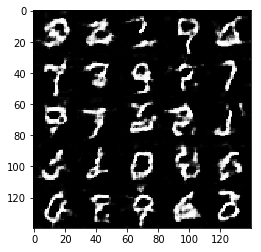

Epoch 1/2 Step 900... Discriminator Loss: 1.2144... Generator Loss: 1.3219
Epoch 1/2 Step 1000... Discriminator Loss: 1.2307... Generator Loss: 1.2667


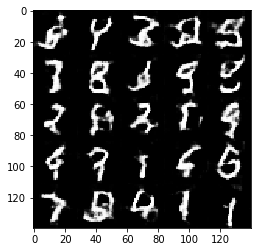

Epoch 1/2 Step 1100... Discriminator Loss: 1.4580... Generator Loss: 0.6498
Epoch 1/2 Step 1200... Discriminator Loss: 1.2274... Generator Loss: 1.0959


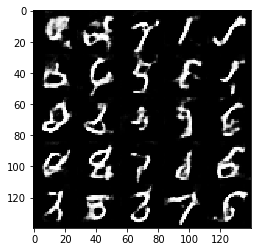

Epoch 1/2 Step 1300... Discriminator Loss: 1.4036... Generator Loss: 0.8512
Epoch 1/2 Step 1400... Discriminator Loss: 1.3708... Generator Loss: 1.0411


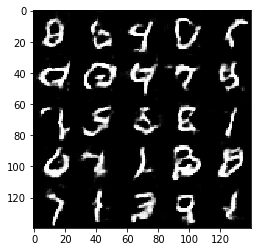

Epoch 1/2 Step 1500... Discriminator Loss: 1.3226... Generator Loss: 0.8749
Epoch 1/2 Step 1600... Discriminator Loss: 1.3597... Generator Loss: 0.9306


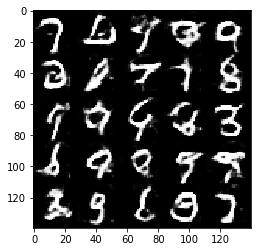

Epoch 1/2 Step 1700... Discriminator Loss: 1.2107... Generator Loss: 1.0206
Epoch 1/2 Step 1800... Discriminator Loss: 1.1471... Generator Loss: 1.1980


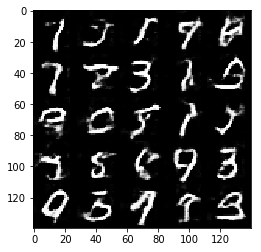

Epoch 2/2 Step 1900... Discriminator Loss: 1.1647... Generator Loss: 1.1328
Epoch 2/2 Step 2000... Discriminator Loss: 1.1972... Generator Loss: 0.8410


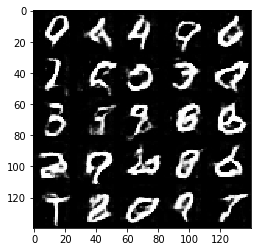

Epoch 2/2 Step 2100... Discriminator Loss: 1.2194... Generator Loss: 1.1662
Epoch 2/2 Step 2200... Discriminator Loss: 1.3127... Generator Loss: 0.9643


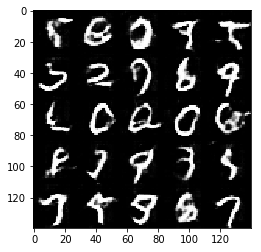

Epoch 2/2 Step 2300... Discriminator Loss: 1.1177... Generator Loss: 0.9670
Epoch 2/2 Step 2400... Discriminator Loss: 1.2347... Generator Loss: 0.8954


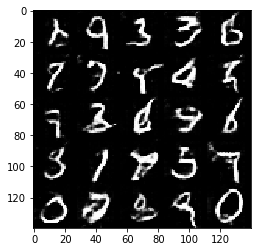

Epoch 2/2 Step 2500... Discriminator Loss: 1.3339... Generator Loss: 1.0564
Epoch 2/2 Step 2600... Discriminator Loss: 1.1869... Generator Loss: 0.9886


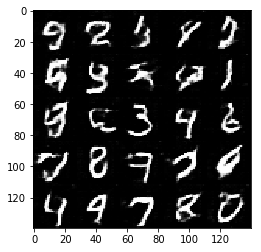

Epoch 2/2 Step 2700... Discriminator Loss: 1.3475... Generator Loss: 0.8118
Epoch 2/2 Step 2800... Discriminator Loss: 1.2411... Generator Loss: 1.0509


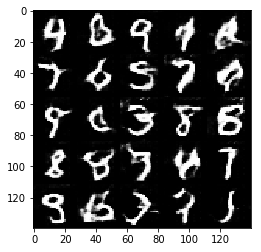

Epoch 2/2 Step 2900... Discriminator Loss: 1.2510... Generator Loss: 0.8695
Epoch 2/2 Step 3000... Discriminator Loss: 1.3028... Generator Loss: 0.8047


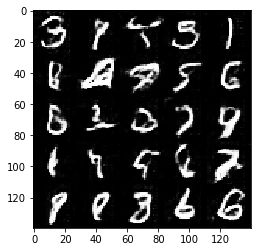

Epoch 2/2 Step 3100... Discriminator Loss: 1.3190... Generator Loss: 0.6116
Epoch 2/2 Step 3200... Discriminator Loss: 1.3936... Generator Loss: 1.3101


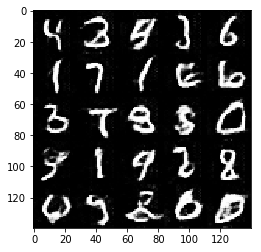

Epoch 2/2 Step 3300... Discriminator Loss: 1.4128... Generator Loss: 0.9681
Epoch 2/2 Step 3400... Discriminator Loss: 1.2243... Generator Loss: 0.8121


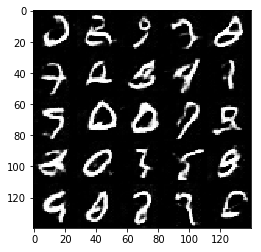

Epoch 2/2 Step 3500... Discriminator Loss: 1.1864... Generator Loss: 1.4138
Epoch 2/2 Step 3600... Discriminator Loss: 1.1703... Generator Loss: 0.8218


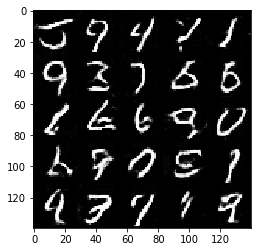

Epoch 2/2 Step 3700... Discriminator Loss: 1.1790... Generator Loss: 1.0205


In [18]:
batch_size = 32#50
z_dim = 100
learning_rate = 0.0002#0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1 Step 100... Discriminator Loss: 1.1732... Generator Loss: 1.1871
Epoch 1/1 Step 200... Discriminator Loss: 0.9851... Generator Loss: 1.6942


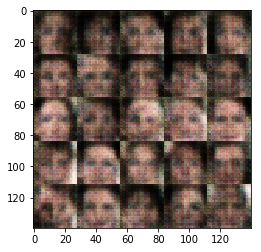

Epoch 1/1 Step 300... Discriminator Loss: 1.1474... Generator Loss: 0.8686
Epoch 1/1 Step 400... Discriminator Loss: 0.7650... Generator Loss: 2.2970


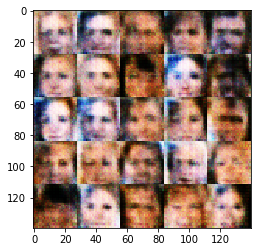

Epoch 1/1 Step 500... Discriminator Loss: 0.8800... Generator Loss: 1.4255
Epoch 1/1 Step 600... Discriminator Loss: 1.1033... Generator Loss: 1.1725


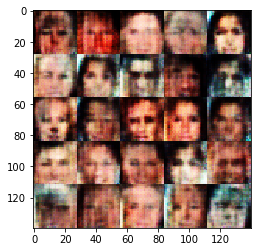

Epoch 1/1 Step 700... Discriminator Loss: 1.6782... Generator Loss: 1.1392
Epoch 1/1 Step 800... Discriminator Loss: 1.0428... Generator Loss: 1.2837


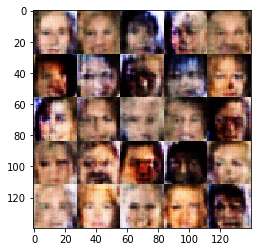

Epoch 1/1 Step 900... Discriminator Loss: 1.2590... Generator Loss: 0.8912
Epoch 1/1 Step 1000... Discriminator Loss: 0.9668... Generator Loss: 1.4021


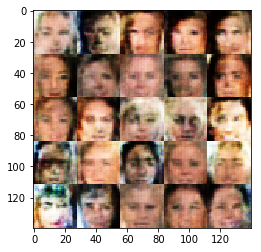

Epoch 1/1 Step 1100... Discriminator Loss: 0.7341... Generator Loss: 2.0103
Epoch 1/1 Step 1200... Discriminator Loss: 1.2048... Generator Loss: 1.1102


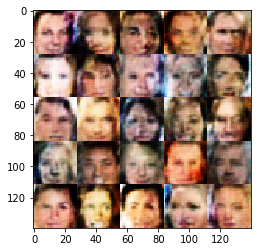

Epoch 1/1 Step 1300... Discriminator Loss: 1.0105... Generator Loss: 1.3983
Epoch 1/1 Step 1400... Discriminator Loss: 1.1457... Generator Loss: 1.3061


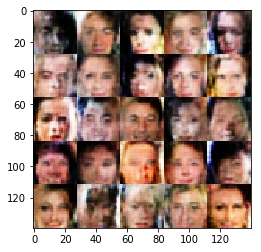

Epoch 1/1 Step 1500... Discriminator Loss: 1.2050... Generator Loss: 0.9492
Epoch 1/1 Step 1600... Discriminator Loss: 1.3441... Generator Loss: 1.0385


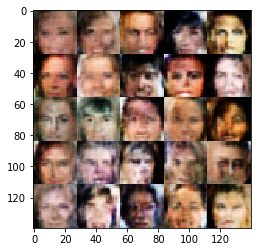

Epoch 1/1 Step 1700... Discriminator Loss: 1.5461... Generator Loss: 0.7328
Epoch 1/1 Step 1800... Discriminator Loss: 0.9354... Generator Loss: 1.4154


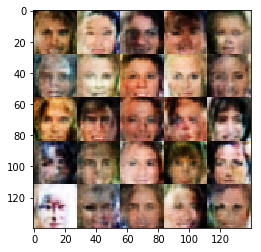

Epoch 1/1 Step 1900... Discriminator Loss: 1.2842... Generator Loss: 0.9185
Epoch 1/1 Step 2000... Discriminator Loss: 1.1600... Generator Loss: 0.9676


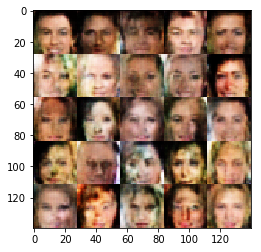

Epoch 1/1 Step 2100... Discriminator Loss: 1.2043... Generator Loss: 1.3876
Epoch 1/1 Step 2200... Discriminator Loss: 0.9074... Generator Loss: 1.2492


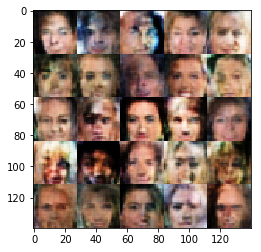

Epoch 1/1 Step 2300... Discriminator Loss: 1.4882... Generator Loss: 0.8181
Epoch 1/1 Step 2400... Discriminator Loss: 1.2640... Generator Loss: 1.1308


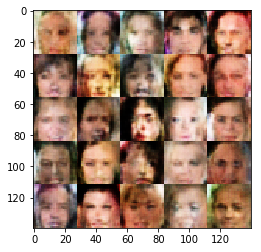

Epoch 1/1 Step 2500... Discriminator Loss: 1.1162... Generator Loss: 0.8657
Epoch 1/1 Step 2600... Discriminator Loss: 1.2727... Generator Loss: 1.1907


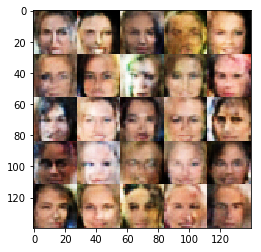

Epoch 1/1 Step 2700... Discriminator Loss: 1.1210... Generator Loss: 1.0535
Epoch 1/1 Step 2800... Discriminator Loss: 1.3186... Generator Loss: 0.7208


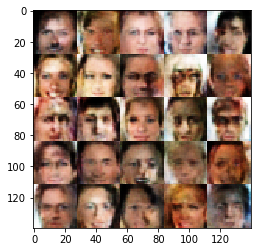

Epoch 1/1 Step 2900... Discriminator Loss: 1.1705... Generator Loss: 1.1951
Epoch 1/1 Step 3000... Discriminator Loss: 1.4528... Generator Loss: 0.7721


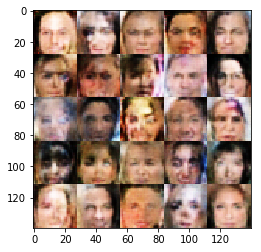

Epoch 1/1 Step 3100... Discriminator Loss: 1.5086... Generator Loss: 0.7383
Epoch 1/1 Step 3200... Discriminator Loss: 1.2949... Generator Loss: 1.0429


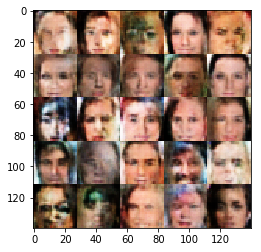

Epoch 1/1 Step 3300... Discriminator Loss: 1.2320... Generator Loss: 0.6354
Epoch 1/1 Step 3400... Discriminator Loss: 1.2211... Generator Loss: 1.0889


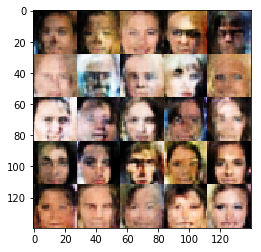

Epoch 1/1 Step 3500... Discriminator Loss: 0.8057... Generator Loss: 2.5371
Epoch 1/1 Step 3600... Discriminator Loss: 1.3457... Generator Loss: 0.8704


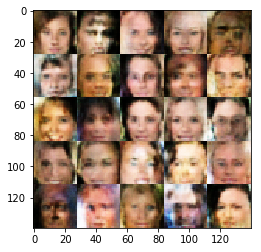

Epoch 1/1 Step 3700... Discriminator Loss: 1.4467... Generator Loss: 0.6487
Epoch 1/1 Step 3800... Discriminator Loss: 1.1585... Generator Loss: 1.0381


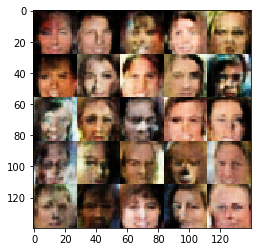

Epoch 1/1 Step 3900... Discriminator Loss: 1.1461... Generator Loss: 1.0417
Epoch 1/1 Step 4000... Discriminator Loss: 1.0616... Generator Loss: 1.8875


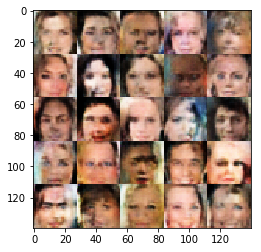

Epoch 1/1 Step 4100... Discriminator Loss: 1.3910... Generator Loss: 0.9456
Epoch 1/1 Step 4200... Discriminator Loss: 1.3372... Generator Loss: 0.7944


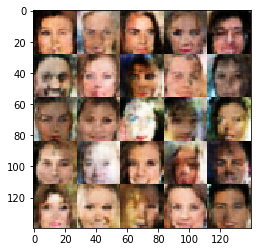

Epoch 1/1 Step 4300... Discriminator Loss: 1.1816... Generator Loss: 0.8921
Epoch 1/1 Step 4400... Discriminator Loss: 1.2529... Generator Loss: 1.1413


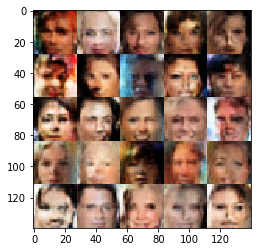

Epoch 1/1 Step 4500... Discriminator Loss: 1.1491... Generator Loss: 1.2702
Epoch 1/1 Step 4600... Discriminator Loss: 1.0065... Generator Loss: 1.4193


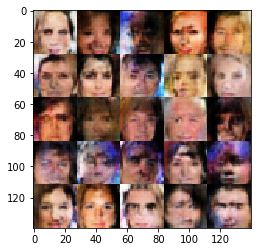

Epoch 1/1 Step 4700... Discriminator Loss: 0.8902... Generator Loss: 1.7659
Epoch 1/1 Step 4800... Discriminator Loss: 0.8102... Generator Loss: 1.5352


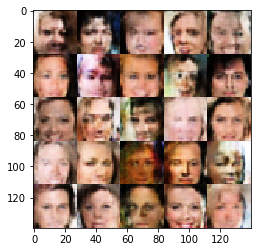

Epoch 1/1 Step 4900... Discriminator Loss: 1.1638... Generator Loss: 0.8909
Epoch 1/1 Step 5000... Discriminator Loss: 1.1148... Generator Loss: 1.3328


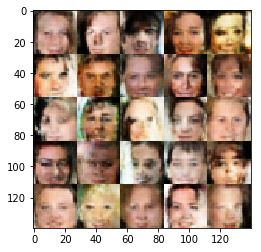

Epoch 1/1 Step 5100... Discriminator Loss: 1.4079... Generator Loss: 0.9591
Epoch 1/1 Step 5200... Discriminator Loss: 1.1973... Generator Loss: 1.1684


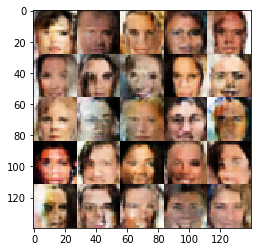

Epoch 1/1 Step 5300... Discriminator Loss: 1.2354... Generator Loss: 1.0683
Epoch 1/1 Step 5400... Discriminator Loss: 0.8851... Generator Loss: 1.6982


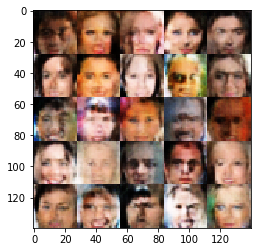

Epoch 1/1 Step 5500... Discriminator Loss: 1.0575... Generator Loss: 1.5419
Epoch 1/1 Step 5600... Discriminator Loss: 1.1269... Generator Loss: 1.4360


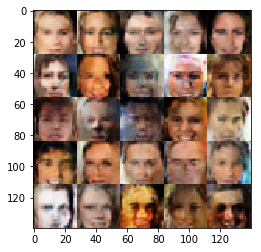

Epoch 1/1 Step 5700... Discriminator Loss: 1.2437... Generator Loss: 1.3483
Epoch 1/1 Step 5800... Discriminator Loss: 1.2064... Generator Loss: 1.2276


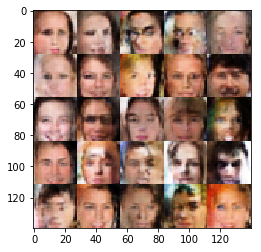

Epoch 1/1 Step 5900... Discriminator Loss: 1.1489... Generator Loss: 1.1134
Epoch 1/1 Step 6000... Discriminator Loss: 1.3756... Generator Loss: 0.7918


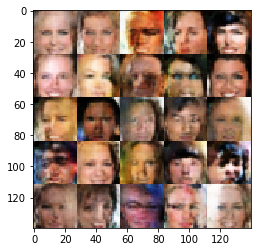

Epoch 1/1 Step 6100... Discriminator Loss: 1.1500... Generator Loss: 1.0508
Epoch 1/1 Step 6200... Discriminator Loss: 0.9938... Generator Loss: 1.1743


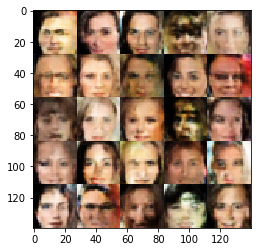

Epoch 1/1 Step 6300... Discriminator Loss: 1.2349... Generator Loss: 1.2867


In [19]:
batch_size = 32#50
z_dim = 100
learning_rate = 0.0002#0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。